In [3]:
import numpy as np
import math
import scipy.io
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [4]:
matdata = scipy.io.loadmat('file.mat')

In [5]:
# This is just a small fix in data to remove micro-granularity...
# ... and save training time
def process_times(times):
    return [int(val/1000) for val in times]

# Process inputs
sparse_u = matdata['u']
observed_y = matdata['y'].flatten()[0:-1]
tu = process_times(matdata['tu'].flatten())
ty = process_times(matdata['ty'].flatten())[0:-1] #observed
y0 = observed_y[0]
y0

17.34290235597689

In [8]:
# get matrix product of B0*U as per the paper 
def get_B_theta_u_product(time, theta1, theta2):
    res = 0.0
    i = 0
    while time >= 1:
        b_k = (theta1/(theta1 - theta2)) * (math.exp(-1*theta2*time) - math.exp(-1*theta1*time))
        u_k = sparse_u[i][0]
        res += b_k * u_k
        i += 1
        time -= 1

    return res

# model is defined as yk = A_0 * y_0 + (B_0_vec * u_vec)
def get_estimated_y(theta1, theta2):
    pred_y = []
    
    # continous y is estimated for all times tu
    for time_idx in tu:
        A_theta = math.exp(-1*theta2*time_idx)
        B_theta_u_prod = get_B_theta_u_product(time_idx, theta1, theta2)
        
        y_k = A_theta*y0 + B_theta_u_prod
        # print(y_k, A_theta, y0, B_theta_u_prod)
        pred_y.append(y_k)
    
    return pred_y

# objective fuction returns the error in the estimation...
# ... the our goal is to minimize the error generated by the objective func.
def objective_function(theta):
    estimated_y_arr = get_estimated_y(theta[0], theta[1])
    interpolated_y = np.interp(ty, tu, estimated_y_arr)
    # print(len(interpolated_y), len(interpolated_y))
    error = np.sum((interpolated_y - observed_y) ** 2)
    
    #error = 0
    
    #for i in range(0, len(observed_y)):
        # Since the size of estimated_y (continous) is tu...
        # ... We make sure to scale the index before comparing
        #error += (estimated_y_arr[i*5] - observed_y[i])**2
    
    return error

In [24]:
## BLOCK TO ESTIMATE THETAS ####

# Initial base value for the model parameters - thetas
init_theta1 = 0.03
init_theta2 = 1.05

res = minimize(objective_function, (init_theta1, init_theta2), method='Nelder-Mead')
estimated_theta1, estimated_theta2 = res.x
estimated_theta1, estimated_theta1

(0.7605612229047232, 0.7605612229047232)

In [21]:
# With the estimated theta values, predict the continous y at tu times
predicted_y = get_estimated_y(estimated_theta1, estimated_theta2)

In [22]:
len(predicted_y), len(observed_y)

(820, 164)

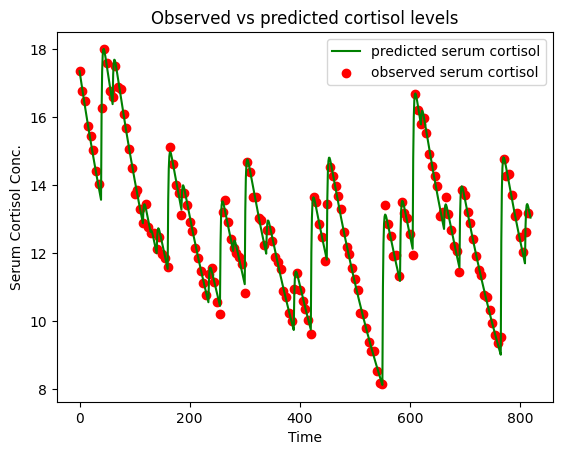

In [23]:
## BLOCK TO PLOT AND COMPARE ##
plt.plot(tu, predicted_y, color='g', label='predicted serum cortisol')
plt.scatter(ty, observed_y, color='r', label='observed serum cortisol')

plt.xlabel("Time")
plt.ylabel("Serum Cortisol Conc.")
plt.title("Observed vs predicted cortisol levels")
plt.legend()

plt.show()

In [ ]:
##### End of code blocks ####